In [1]:
import warnings
warnings.filterwarnings('ignore')
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
plt.style.use('ggplot')
from statsmodels.tsa.seasonal import seasonal_decompose

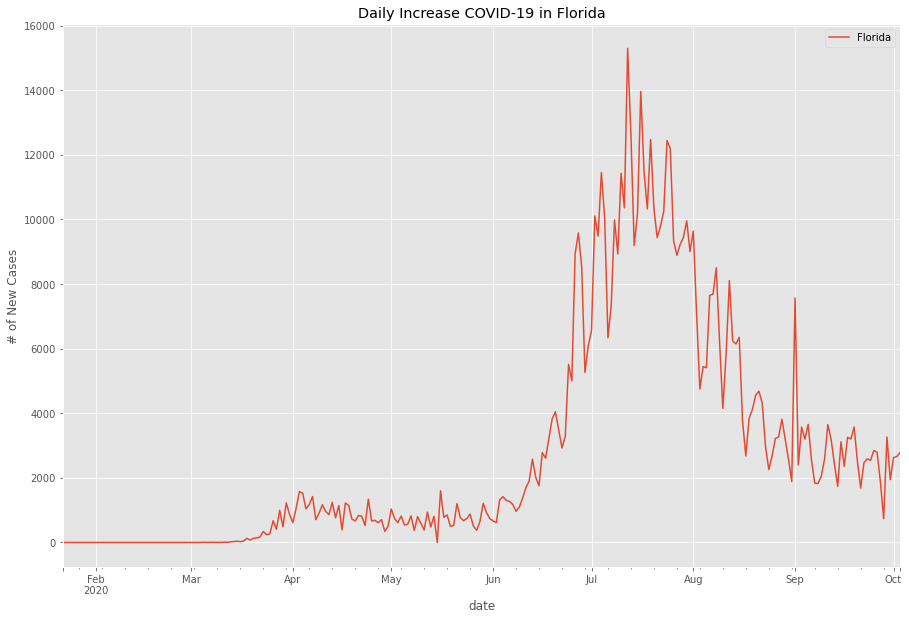

In [3]:
df = pd.read_csv('national_positive_increase.csv')

# Rename 'Unnamed' to 'date'
df = df.rename(columns={'Unnamed: 0' : 'date'})

# Changing 'date' to date-time 
df['date'] = pd.to_datetime(df['date'])

# Set to index
df = df.set_index('date')

df = df.asfreq('D')

# Florida
fl = df['FL_positiveIncrease']
fl.plot(figsize=(15, 10), label='Florida')

plt.ylabel('# of New Cases')
plt.title('Daily Increase COVID-19 in Florida')
plt.legend()
plt.show();
